## Load package

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint

In [2]:
from data import DeepCGH_Datasets
from loss import CustomLoss
from model import unet

### Define Parameter

In [3]:
shape = (1024,1024,1)
IF = 16
n_kernels = [ 128, 256, 512]
plane_distance = 0.005
wavelength = 658e-9
ps = 5*1e-6
zs = [plane_distance*x for x in np.arange(1, (shape[-1]-1)//2+1)][::-1] + \
      [plane_distance*x for x in np.arange(1, (shape[-1]-1)//2+1)]
      
lr = 1e-3
batch_size = 2
epochs = 1

#### Create Data Generator

In [4]:
dset_tra = DeepCGH_Datasets(
    shape=shape,
    object_type='Disk',
    object_size=5,
    object_count=[1, 2],
    intensity=[0.2, 1],
    normalize=True,
    centralized=False,
    N=10000,
    name='target',
)

dset_val = DeepCGH_Datasets(
    shape=shape,
    object_type='Disk',
    object_size=5,
    object_count=[1, 2],
    intensity=[0.2, 1],
    normalize=True,
    centralized=False,
    N=1000,
    name='target',
)

dgen_tra = dset_tra.debug_generator(batch_size)
dgen_val = dset_val.debug_generator(batch_size)

#### Build Model and Loss Function

In [5]:
model = unet(shape, n_kernels, IF)
model.summary()

model.compile(optimizer=Adam(lr=lr),
              loss=CustomLoss(shape, zs, wavelength, ps))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
target (InputLayer)             [(None, 1024, 1024,  0                                            
__________________________________________________________________________________________________
Interleave (Lambda)             (None, 64, 64, 256)  0           target[0][0]                     
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 128)  295040      Interleave[0][0]                 
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 128)  512         conv2d[0][0]                     
______________________________________________________________________________________________

#### Train Model

In [6]:
callbacks_list = [
    ModelCheckpoint("model.h5", save_best_only=True),
    CSVLogger("progress.csv", append=True),
]

model.fit(dgen_tra,
          validation_data=dgen_val,
          callbacks=callbacks_list,
          epochs=epochs)

5000/5000 [==============================] - 734s 146ms/step - loss: 0.1664 - val_loss: 0.0177


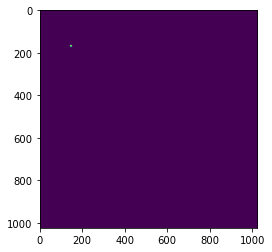

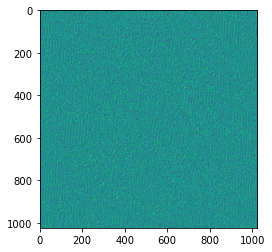

In [7]:
a = dset_val.debug_sample()

load_model('model.h5', compile=False)
b = model.predict(a)

plt.imshow(a[0,:,:,0])
plt.show()

plt.imshow(b[0,:,:,0])
plt.show()